# Content <a class="anchor" id="0"></a>

* [1. Utils](#1) 

* [2. Dataset](#2)
    * [2.1 EDA](#2.1)
    

* [3. Module](#3)
    * [3.1. Config](#3.1)
    
    
* [4. Training](#4)

* [5. Analysis](#5)
    * [5.1. Resnet 50](#5.1)
    * [5.2. Effnet B0](#5.2)
    * [5.3. SwinV2 B](#5.3)
    

* [6. Summary](#6)

* [7. Test Inference](#7)

<a id="1"></a>
## <b>1 <span style='color:#CF9FFF'>|</span> Utils</b>
* [К оглавлению](#0)

In [1]:
import torch
import torchvision
import pytorch_lightning as pl
from torchmetrics import (
    MetricTracker,
    MetricCollection,
    Accuracy,
    F1Score,
)
from transformers import CLIPProcessor, CLIPModel
import albumentations as albu
import wandb

import random
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

from pathlib import Path
from typing import Optional, Tuple, Union, Dict, Iterable

import os
import gc
from kaggle_secrets import UserSecretsClient

In [2]:
DEFAULT_RANDOM_SEED = 42

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [3]:
pl.utilities.seed.seed_everything(42)
seedEverything(42)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/seed.py:48: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_fabric.utilities.seed.seed_everything` instead.
  "`pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be"


In [4]:
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api")
wandb.login(key=wandb_api_key) # подключаемся к wandb чтобы логгировать эксперименты

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

<a id="2"></a>
## <b>2 <span style='color:#CF9FFF'>|</span> Dataset</b>
* [К оглавлению](#0)

С помощью предобученной модели CLIP разметим датасет на 2 класса: такси/не такси.

In [5]:
class CLIPDataset:
    def __init__(self,
                 model_name: str = "openai/clip-vit-base-patch16",
                 images_folder: Path = "/kaggle/input/courseworktaxi/solaris_damage_0_4_3/images",
                 class_names: Tuple[str] = ("a photo of personal car", "a photo of taxi"),
                ) -> None:
        self.model = CLIPModel.from_pretrained(model_name).to("cuda")
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.images_folder = images_folder
        self.class_names = class_names
        
    def __getitem__(self, idx: int) -> Image:
        image_path =  os.path.join(self.images_folder, os.listdir(self.images_folder)[idx])
        image = Image.open(image_path)
        return image
    
    def __len__(self) -> int:
        return len(os.listdir(self.images_folder))
    
    def _get_label(self, idx: int, confidence: float = 0.70) -> Optional[Tuple[int]]:
        try:
            image = self.__getitem__(idx=idx)
            inputs = self.processor(text=self.class_names, images=image, return_tensors="pt", padding=True).to("cuda")
            outputs = self.model(**inputs)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1)
            if torch.max(probs) >= confidence:
                return (np.argmax(probs.detach().cpu().numpy()), idx)
            else:
                return None
        except:
            return None
        
    def get_labels(self) -> Tuple[int]:
        return [
            self._get_label(idx) for idx in tqdm(range(self.__len__()))
            if self._get_label(idx) is not None
        ]
                
    def balance_labels(self, labels: Tuple[int], class_samples: Tuple[int] = (609,609)) -> Tuple[int]:
        df = pd.DataFrame(labels,columns=["labels","idxs"])
        df = df.drop_duplicates(subset="idxs")
        
        df_false = df[df.labels==0].sample(class_samples[0], random_state=42)
        df_true = df[df.labels==1].sample(class_samples[1], random_state=42)

        df = pd.concat([df_true, df_false])
        df = shuffle(df)
        return list(zip(df.labels.values, df.idxs.values))

In [ ]:
dataset = CLIPDataset()
labels = dataset.get_labels()
labels = dataset.balance_labels(labels)
np.savetxt("labels.txt", np.array(labels, dtype="int32"))

In [7]:
class TaxiDataset(torch.utils.data.Dataset):
    def __init__(self,
                 images_path: Path,
                 labels_path: Path,
                 transforms: albu.augmentations.transforms = None,
                 split: str = "train",
                 resize_size: Tuple[int] = (224, 224)
                ) -> None:
        self._images_path = images_path
        self._images = os.listdir(images_path)
        self._labels_path = labels_path
        self._labels = np.loadtxt(labels_path, dtype=np.int32)
        self._transforms = transforms
        self._width, self._height = resize_size[0], resize_size[1]
        
        if split == "train":
            self._labels = self._labels[:671]
        elif split == "val":
            self._labels = self._labels[671:997]
            self._transforms = None
        else:
            self._labels = self._labels[997:]
            self._transforms = None
            
        
    def __getitem__(self, idx) -> Tuple[np.array, int]:
        label, image_idx = self._labels[idx]
        image_path = os.path.join(self._images_path, self._images[image_idx])
        image = Image.open(image_path)
        batch = np.array(image)
        
        if self._transforms is not None:
            batch = self._transforms(image=batch)["image"]
            
        batch = albu.augmentations.geometric.resize.Resize(self._width, self._height)(image=batch)
        batch = albu.Normalize()(image=batch["image"])
        image = batch["image"].transpose(2, 0 , 1)
        return image, label
    
    def __len__(self) -> int:
        return len(self._labels)

In [8]:
class UnNormalize(object):
    def __init__(self, mean: Iterable[float], std: Iterable[float]):
        self.mean = mean
        self.std = std

    def __call__(self, tensor: torch.Tensor) -> torch.Tensor: 
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

<a id="2.1"></a>
## <b>2.1 <span style='color:#CF9FFF'>|</span> EDA </b>
* [К оглавлению](#0)

Для оценки точности и надежности разметки, вручную провереbv несколько семплов изображений, представленных моделью CLIP.

SPLIT: train
0 class : 319, 1 class : 352


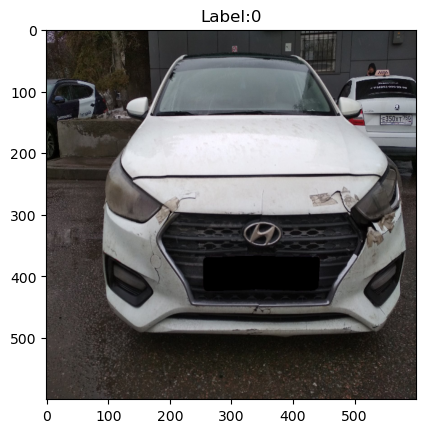

SPLIT: val
0 class : 172, 1 class : 154


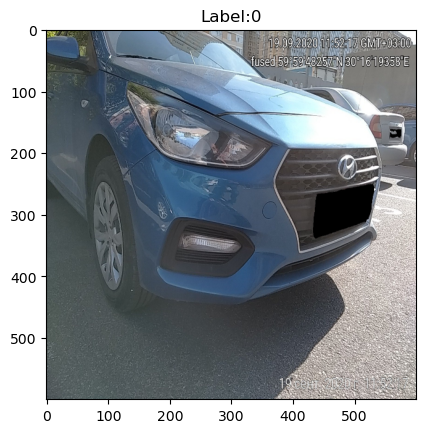

SPLIT: test
0 class : 118, 1 class : 103


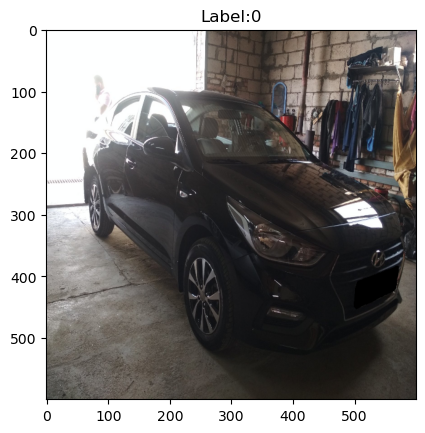

In [9]:
for split in ["train", "val", "test"]:

    print("================")
    print(f"SPLIT: {split}")

    dataset = TaxiDataset(
        "/kaggle/input/courseworktaxi/solaris_damage_0_4_3/images",
        "/kaggle/working/labels.txt",
        transforms=None,
        split=split,
        resize_size=(600,600)
    )
    
    labels = np.array(dataset._labels)
    labels_0 = labels[:, 0] == 0
    labels_1 = labels[:, 0] == 1
    
    print(f"0 class : {len(labels[:,0][labels_0])}, 1 class : {len(labels[:,0][labels_1])}")

    sample_idxs = np.random.choice(np.arange(len(dataset)),size=1)

    for idx in sample_idxs:
        img, label = dataset[idx]
        unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        unnorm_img = unnorm(torch.tensor(img)).numpy()
        unnorm_img = np.moveaxis(unnorm_img,(0,1,2),(2,0,1))
        plt.imshow(unnorm_img)
        plt.title(f"Label:{label}")
        plt.show()

 Результаты визуальной проверки подтверждают, что разметка, полученная моделью CLIP, является качественной и достоверной. Кроме того, класси в нашей задаче являются сбалансированными.

In [10]:
del dataset
gc.collect()
torch.cuda.empty_cache()

<a id="3"></a>
## <b>3 <span style='color:#CF9FFF'>|</span> Training Module </b>
* [К оглавлению](#0)

В данном исследовании выбраны две метрики для оценки качества разметки, полученной моделью CLIP: accuracy (точность) и F1-мера. Обе метрики являются стандартными мерами в задачах классификации, и были выбраны исходя из сбалансированности классов в нашем наборе данных.

In [11]:
class TaxiModule(pl.LightningModule):
    def __init__(self, config) -> None:
        super().__init__()
        self._config = config
        self.model = MODELS[config["model_type"]]
        self.criterion = CRITERIONS[config["criterion_type"]]
        self.train_metrics = MetricTracker(
            MetricCollection([
            Accuracy(task="binary"),
            F1Score(task="binary"),
            ]), maximize=[True, True]
        )
        self.val_metrics = MetricTracker(
            MetricCollection([
            Accuracy(task="binary"),
            F1Score(task="binary"),
            ]), maximize=[True, True]
        )
        self.test_metrics = MetricTracker(
            MetricCollection([
            Accuracy(task="binary"),
            F1Score(task="binary"),
            ]), maximize=[True, True]
        )
        
        
    def _get_dataset(self, split: str, **dataset_kwargs) -> TaxiDataset:
        params = self._config["dataset_params"]
        return TaxiDataset(split=split, **params, **dataset_kwargs)
    
    def _get_dataloader(self, dataset: TaxiDataset, **dataloader_kwargs) -> torch.utils.data.DataLoader:
        params = self._config["dataloader_params"]
        return torch.utils.data.DataLoader(dataset, **params, **dataloader_kwargs)
        
    def train_dataloader(self) -> torch.utils.data.DataLoader:
        train_dataset = self._get_dataset(split="train")
        return self._get_dataloader(train_dataset, shuffle=True)
    
    def val_dataloader(self) -> torch.utils.data.DataLoader:
        val_dataset = self._get_dataset(split="val")
        return self._get_dataloader(val_dataset, shuffle=False)
    
    def test_dataloader(self) -> torch.utils.data.DataLoader:
        test_dataset = self._get_dataset(split="test")
        return self._get_dataloader(test_dataset, shuffle=False)
    
    def configure_optimizers(self, **optimizer_kwargs) -> torch.optim.Optimizer:
        params = self._config["optimizer_params"]
        optimizer = OPTIMIZERS[config["optimizers_type"]](
            self.model.parameters(),
            **params,
            **optimizer_kwargs,
            )
        return optimizer
        
    def training_step(self, batch: Tuple[torch.Tensor, int], batch_idx: int) -> Dict[str, float]:
        self.train_metrics.increment()
        images, labels = batch
        preds = self.model(images).view(-1)
        loss = self.criterion(preds, labels.float())
        self.train_metrics.update(preds, labels)
        self.log("train_loss", loss, on_step=False, on_epoch=True,sync_dist=True)
        self.log_dict({(k+" train"):v for k,v in self.train_metrics.compute().items()},on_step=True, on_epoch=False,sync_dist=True)
        return {"loss": loss}
        
    def validation_step(self, batch: Tuple[torch.Tensor, int], batch_idx: int) -> Dict[str, float]:
        self.val_metrics.increment()
        images, labels = batch
        preds = self.model(images).view(-1)
        loss = self.criterion(preds, labels.float())
        self.val_metrics.update(preds, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True,sync_dist=True)
        self.log_dict({(k+" val"):v for k,v in self.val_metrics.compute().items()},on_step=False,on_epoch=True,sync_dist=True)
        return {"loss": loss}
        
    def test_step(self, batch: Tuple[torch.Tensor, int], batch_idx: int) -> Dict[str, float]:
        self.test_metrics.increment()
        images, labels = batch
        preds = self.model(images).view(-1)
        loss = self.criterion(preds, labels.float())
        self.test_metrics.update(preds, labels)
        self.log("test_loss", loss, on_step=False, on_epoch=True,sync_dist=True)
        self.log_dict({(k+" test"):v for k,v in self.test_metrics.compute().items()},on_step=False,on_epoch=True,sync_dist=True)
        return {"loss": loss}

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.fc = torch.nn.Linear(2048,1)

effnetb0 = torchvision.models.efficientnet_b0(pretrained=True)
effnetb0.classifier[1] = torch.nn.Linear(1280, 1)

swinv2b = torchvision.models.swin_v2_b(pretrained=True)
swinv2b.head = torch.nn.Linear(1024, 1)

<a id="3.1"></a>
## <b>3.1 <span style='color:#CF9FFF'>|</span> Config</b>
* [К оглавлению](#0)

In [13]:
MODELS = {
    "Resnet50": resnet50,
    "Effnetb0": effnetb0,
    "Swinv2b": swinv2b,
}
CRITERIONS = {
    "BCE": torch.nn.BCEWithLogitsLoss(),
}
OPTIMIZERS = {
    "Adam": torch.optim.Adam,
}

In [14]:
config = {
    "model_type": "Effnetb0",
    "criterion_type": "BCE",
    "optimizers_type": "Adam",
    "optimizer_params": {
        "lr": 3e-2
    },
    "dataloader_params":{
        "batch_size": 128,
        "num_workers": 2,
    },
    "dataset_params":{
        "images_path": "/kaggle/input/courseworktaxi/solaris_damage_0_4_3/images",
        "labels_path": "/kaggle/working/labels.txt",
        "transforms": albu.Compose([
            albu.HorizontalFlip(p=0.7),
            albu.VerticalFlip(p=0.7),
            albu.GridDistortion(p=0.3), 
            albu.Downscale(p=0.3),
            albu.RandomBrightnessContrast(p=0.3),
            albu.PixelDropout(p=0.5),
        ]),
        "resize_size": (224, 224)
    },
}

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1555: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  "Using default interpolation INTER_NEAREST, which is sub-optimal."


<a id="4"></a>
## <b>4 <span style='color:#CF9FFF'>|</span> Training</b>
* [К оглавлению](#0)

In [ ]:
module = TaxiModule(config)
logger = pl.loggers.WandbLogger(project="coursework", name="effnetb0")
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    logger=logger,
    log_every_n_steps=1,
    max_epochs=40,
)
trainer.fit(module)

<a id="5"></a>
## <b>5 <span style='color:#CF9FFF'>|</span> Analysis</b>
* [К оглавлению](#0)

<a id="5.1"></a>
### <b>5.1 <span style='color:#CF9FFF'>|</span> ResNet50</b>

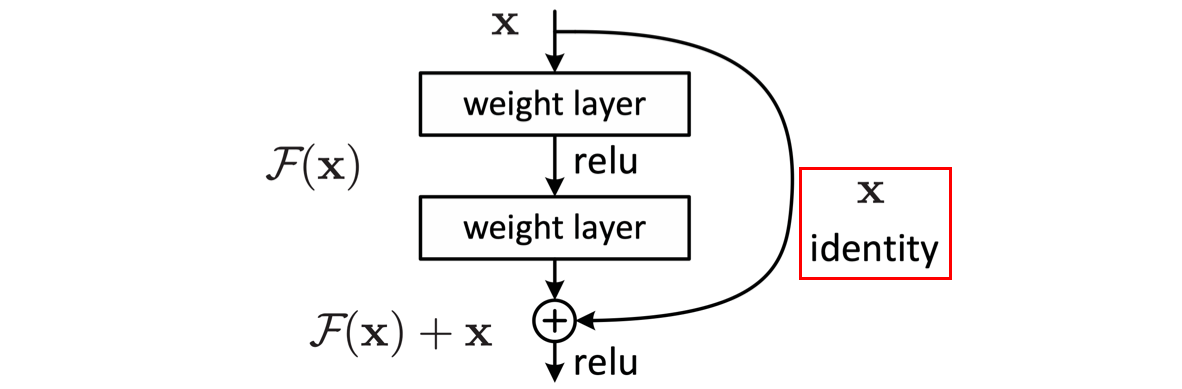

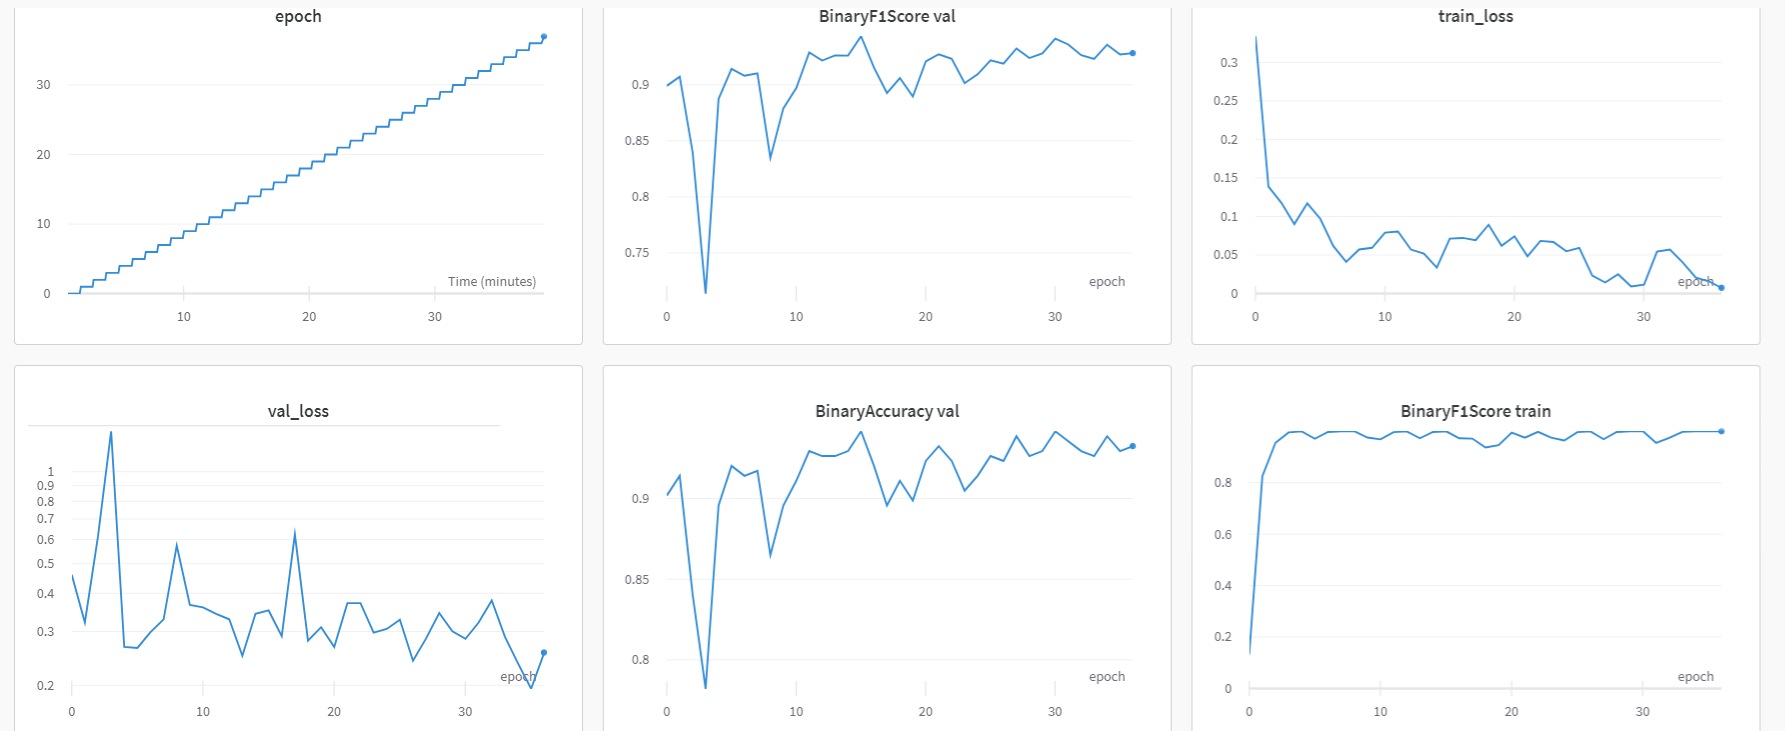

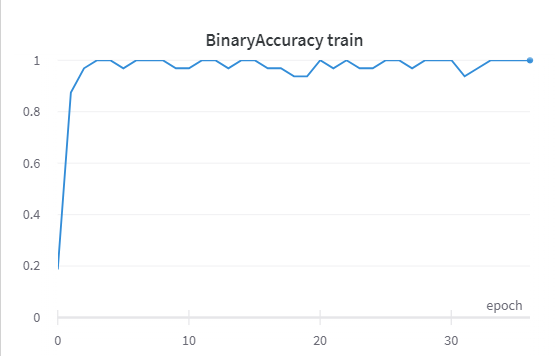

<a id="5.2"></a>
### <b>5.2 <span style='color:#CF9FFF'>|</span> Effnet B0</b>

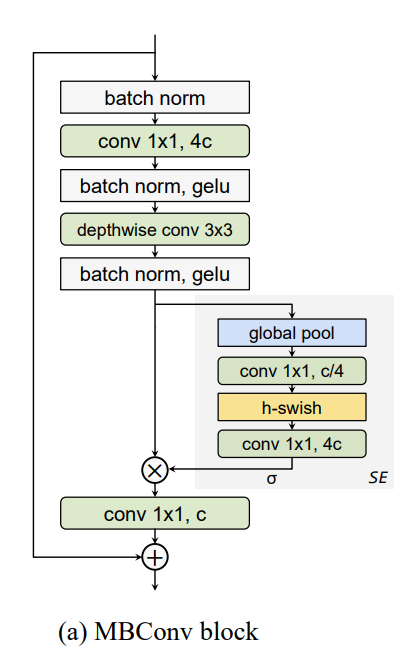

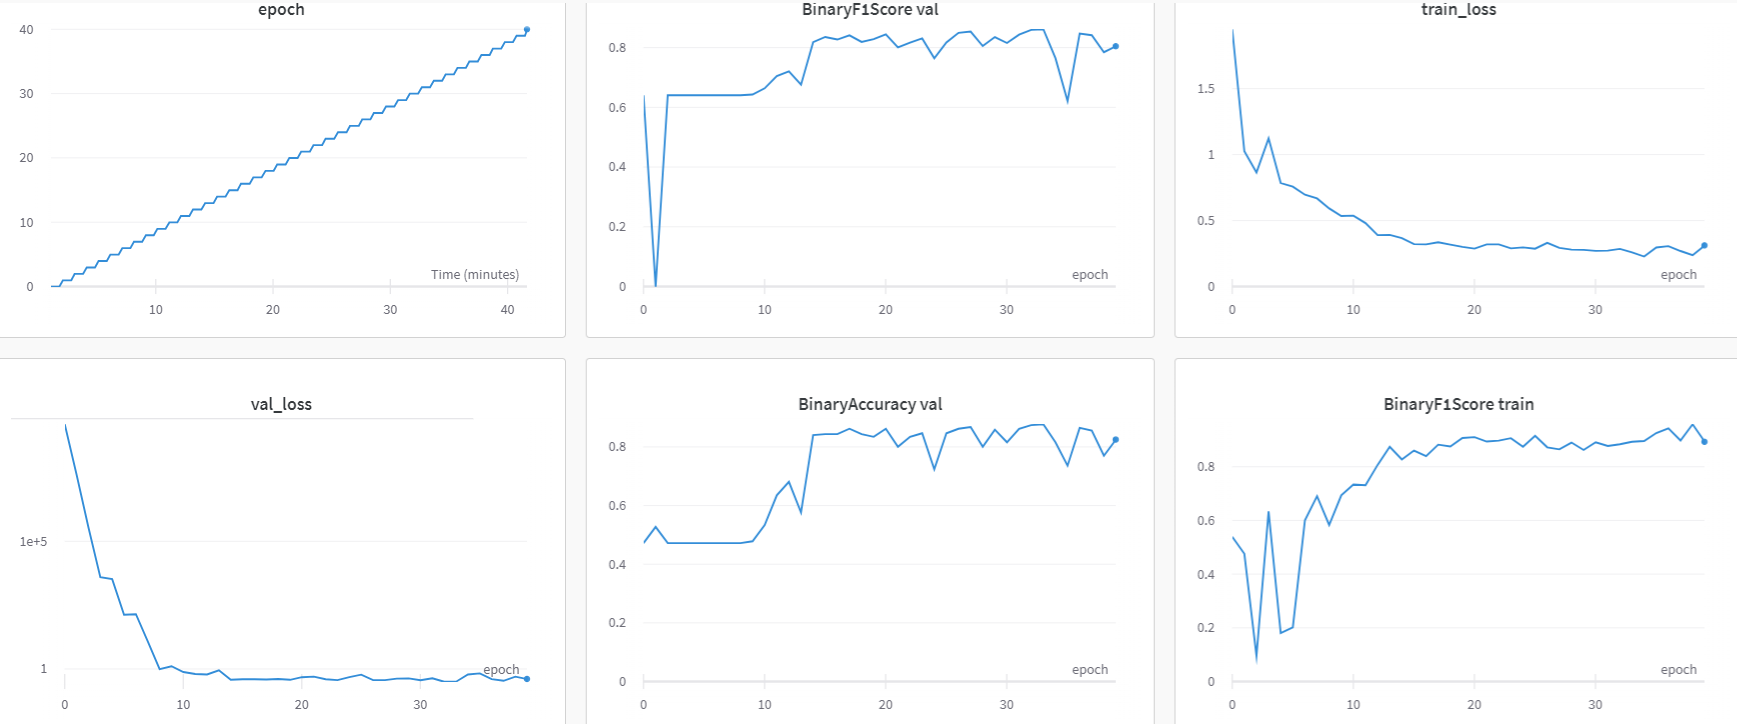

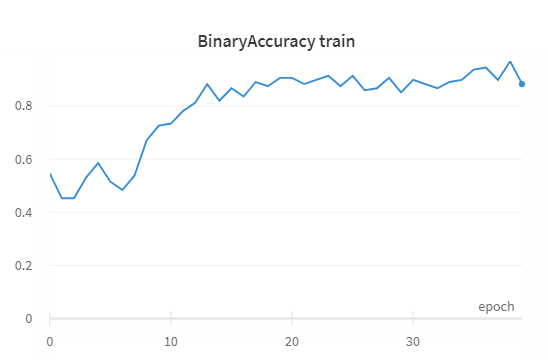

<a id="5.3"></a>
### <b>5.3 <span style='color:#CF9FFF'>|</span> SwinV2-B</b>

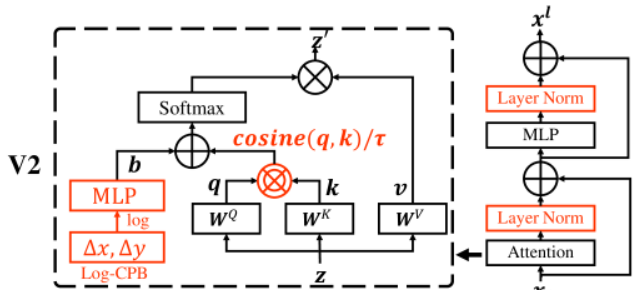

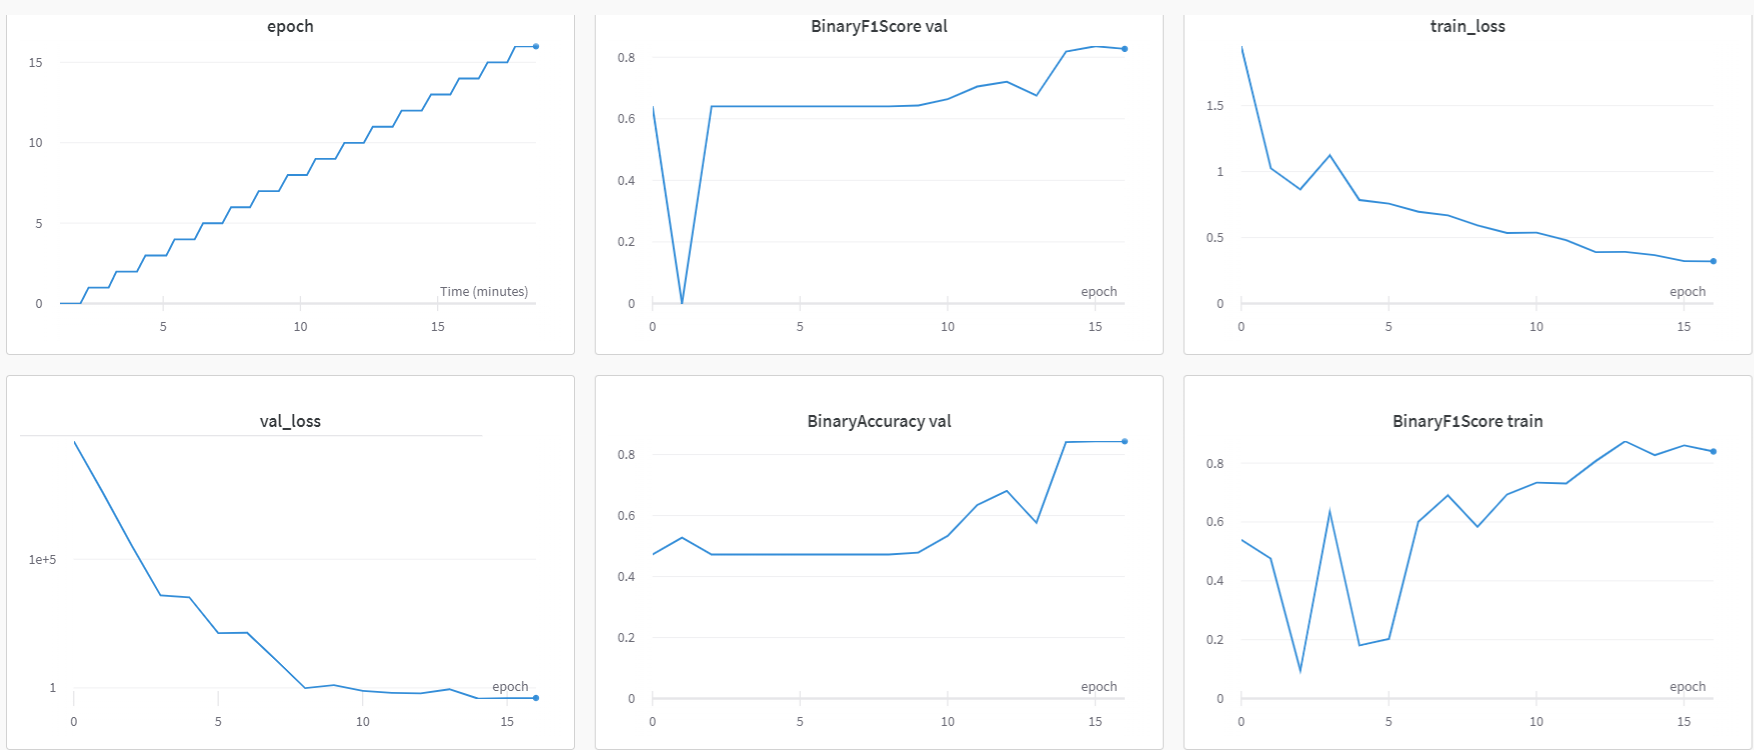

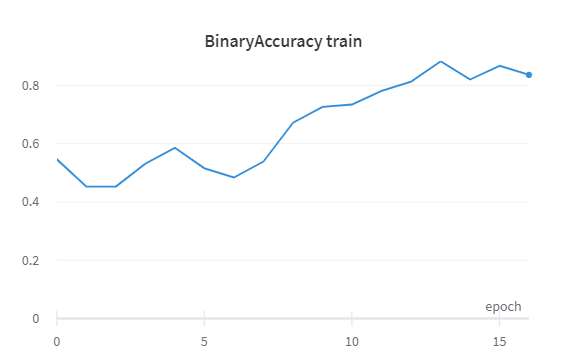

<a id="6"></a>
## <b>6 <span style='color:#CF9FFF'>|</span> Summary</b>
* [К оглавлению](#0)

* **Resnet50**

Модель ResNet-50 демонстрирует стабильную и высокую производительность, что подтверждает её широкое использование в различных задачах компьютерного зрения, однако она является более склонной к переобучению. 

    F1 Score = 0.9189
    Accuracy = 0.9206

* **Effnetb0**

EfficientNet-B0, в свою очередь, достигает приемлемых результатов, но несколько уступает двум другим моделям.

    F1 Score = 0.8120
    Accuracy = 0.8016

* **SwinV2-B** 

SwinV2-B, хотя и требует больше данных и ресурсов для обучения, показывает хорошие метрики производительности, и выделяется как наиболее перспективная модель.

    F1 Score = 0.8271
    Accuracy = 0.8436

<a id="7"></a>
## <b>7 <span style='color:#CF9FFF'>|</span> Test Inference</b>
* [К оглавлению](#0)

Исходя из всего выше сказанного, в качестве итоговой модели на тестовой выборке будем использовать SwinV2-B.

In [19]:
trainer.test()

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:128: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"


Testing: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    BinaryAccuracy test    │    0.8597285151481628     │
│    BinaryF1Score test     │     0.835566520690918     │
│         test_loss         │    0.35612401366233826    │
└───────────────────────────┴───────────────────────────┘

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[{'test_loss': 0.35612401366233826,
  'BinaryAccuracy test': 0.8597285151481628,
  'BinaryF1Score test': 0.835566520690918}]